In [1]:
import json
from functools import partial
from typing import Callable, List, Tuple
import datetime as dt
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
import optax

from jaxsnn.base.types import Array, Spike, Weight
from jaxsnn.event.compose import serial
from jaxsnn.event.dataset import linear_dataset
from jaxsnn.event.leaky_integrate_and_fire import LIF, LIFParameters, RecursiveLIF
from jaxsnn.event.functional import batch_wrapper
from jaxsnn.event.loss import target_time_loss
from jaxsnn.event.plot import (
    plt_accuracy,
    plt_average_spike_time,
    plt_dataset,
    plt_loss,
    plt_no_spike_prob,
    plt_prediction,
    plt_2dloss,
    plt_spikes,
    plt_weights,
    plt_t_spike_neuron
)
from jaxsnn.event.root import ttfs_solver


def loss_and_acc(
    loss_fn: Callable,
    params: List[Weight],
    dataset: Tuple[Spike, Array],
):
    batched_loss = jax.vmap(loss_fn, in_axes=(None, 0))
    loss, (t_first_spike, _) = batched_loss(params, dataset)
    accuracy = np.argmin(dataset[1], axis=-1) == np.argmin(t_first_spike, axis=-1)
    return (
        np.mean(loss),
        np.mean(accuracy),
        t_first_spike,
    )



# neuron params
tau_mem = 1e-2
tau_syn = 5e-3
t_late = tau_syn + tau_mem
t_max = 2 * t_late
v_th = 0.6
p = LIFParameters(tau_mem_inv=1 / tau_mem, tau_syn_inv=1 / tau_syn, v_th=v_th)

# training params
step_size = 1e-3
n_batches = 100
batch_size = 32
epochs = 50

# net
hidden_size = 4
output_size = 2
n_spikes_hidden = 10
n_spikes_output = 20
seed = 42
optimizer_fn = optax.adam

rng = random.PRNGKey(seed)
param_rng, train_rng, test_rng = random.split(rng, 3)
trainset = linear_dataset(
    train_rng, t_max, [n_batches, batch_size], mirror_input=True
)
testset = linear_dataset(
    test_rng, t_max, [n_batches, batch_size], mirror_input=True
)
input_size = trainset[0].idx.shape[-1]


solver = partial(ttfs_solver, tau_mem, p.v_th)

# declare net
init_fn, apply_fn = serial(
    RecursiveLIF(hidden_size, n_spikes=n_spikes_hidden, t_max=t_max, p=p, solver=solver),
    LIF(output_size, n_spikes=n_spikes_output, t_max=t_max, p=p, solver=solver),
)

# init params and optimizer
params = init_fn(param_rng, input_size)

optimizer = optimizer_fn(step_size)
opt_state = optimizer.init(params)

# declare update function
loss_fn = batch_wrapper(partial(target_time_loss, apply_fn, tau_mem))

# define update function
def update(
    input: Tuple[optax.OptState, List[Weight]],
    batch: Tuple[Spike, Array],
):
    opt_state, params = input
    value, grad = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return (opt_state, params), value

def epoch(state, _):
    state, _ = jax.lax.scan(update, state, trainset)
    params = state[1]
    test_result = loss_and_acc(loss_fn, params, testset)
    return state, (test_result, params)

# train the net
(opt_state, params), (res, params_over_time) = jax.lax.scan(
    epoch, (opt_state, params), np.arange(epochs)
)
loss, acc, t_spike = res


class_0 = np.argmin(testset[1], axis=-1) == 0
t_spike_correct = np.where(class_0, t_spike[..., 0], t_spike[..., 1])
t_spike_false = np.where(class_0, t_spike[..., 1], t_spike[..., 0])

trajectory = np.stack(
    (np.mean(t_spike_correct, axis=(1, 2)), np.mean(t_spike_false, axis=(1, 2))),
    axis=1,
)
target = np.array([0.6, 1.0]) * t_max / 4

# plotting
dt_string = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
folder = f"jaxsnn/plots/event/linear/{dt_string}"

In [2]:
from typing import Optional, List
from jaxsnn.base.types import ArrayLike
import numpy as np

from jaxsnn.base.types import Array, Spike
from jaxsnn.event.dataset import Dataset
from matplotlib.pyplot import Axes
import matplotlib.pyplot as plt
import matplotlib as mpl

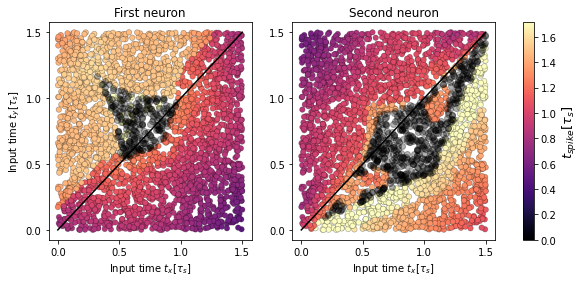

In [63]:
# # loss and accuracy
# fig, ax1 = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
# plt_loss(ax1[0], loss)
# plt_accuracy(ax1[1], acc)
# plt_no_spike_prob(ax1[2], t_spike_correct, t_spike_false)
# fig.tight_layout()
# plt.xlabel("Epoch")

# fig.subplots_adjust(bottom=0.15)
# fig.savefig(f"{folder}_loss.png", dpi=300)

black = np.array([[0, 0, 0, 0.3]])

def plt_t_spike_neuron(fig, axs: List[Axes], dataset: Dataset, t_spike: Array, tau_syn_inv: ArrayLike):
    names = ("First", "Second", "Third")
    n_neurons = t_spike[-1].shape[-1]
    x = dataset[0].time[..., 0].flatten() * tau_syn_inv
    y = dataset[0].time[..., 1].flatten() * tau_syn_inv

    t_spike = t_spike[-1].reshape(-1, n_neurons)

    # normalize all neurons with the same value
    cmap = mpl.colormaps["magma"]
    normalize = np.nanpercentile(np.where(t_spike == np.inf, np.nan, t_spike), 95)
    for i in range(n_neurons):
        score = t_spike[:, i]
        score_no_inf = score[score != np.inf]
        color_ix = np.rint(score_no_inf * 256 / normalize).astype(int)
        colors = cmap(color_ix)
        axs[i].scatter(x[score != np.inf], y[score != np.inf], s=30, facecolor=colors, edgecolor=black, linewidths=0.7)
        axs[i].scatter(x[score == np.inf], y[score == np.inf], facecolor=black, edgecolor=black)
        axs[i].plot(np.linspace(0, 1.5, 100), np.linspace(0, 1.5, 100), c="k")
        axs[i].set_xlabel(r"Input time $t_x [\tau_s]$")
        axs[i].set_xticks(np.linspace(0, 1.5, 4))
        axs[i].set_yticks(np.linspace(0, 1.5, 4))
        if i == 0:
            axs[i].set_ylabel(r"Input time $t_y [\tau_s]$")
        axs[i].title.set_text(f"{names[i]} neuron")

    # Normalizer
    norm = mpl.colors.Normalize(vmin=0, vmax=normalize * tau_syn_inv)

    # creating ScalarMappable
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=axs, location="right")
    cbar.ax.set_ylabel(r"$t_{spike}[\tau_s]$", rotation=90, fontsize=13)

fig, ax1 = plt.subplots(1, 2, figsize=(10, 4))
plt_t_spike_neuron(fig, ax1, testset, t_spike, LIFParameters.tau_syn_inv)
# plt.tight_layout()
plt.show()

# plt_average_spike_time(ax2[2], t_spike_correct, t_spike_false, target)
# plt_2dloss(ax3[1], trajectory, t_max, target, 100, tau_mem)

# fig, ax1 = plt.subplots(1, 2, figsize=(7, 4))
# plt_dataset(ax1[0], testset, LIFParameters.tau_syn_inv)
# plt_prediction(ax1[1], testset, t_spike, LIFParameters.tau_syn_inv)

# fig.tight_layout()
# fig.savefig(f"{folder}_classification.png", dpi=150)

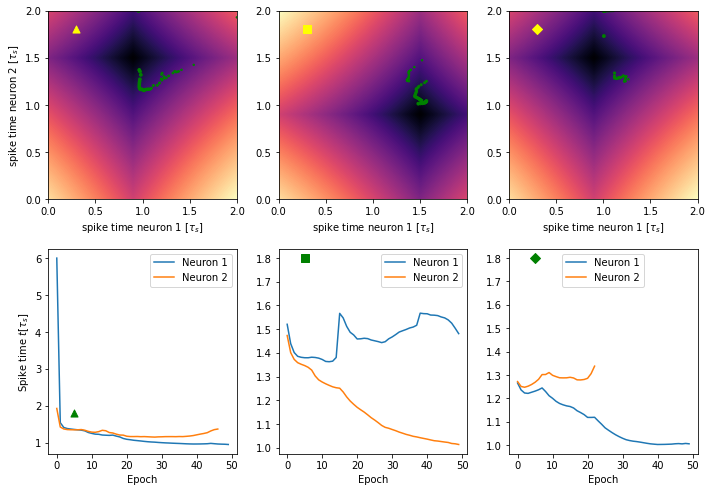

In [170]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
items = ((0, 0, "^"), (0, 1, "s"), (0, 2, "D"))
for i, (ix1, ix2, marker) in enumerate(items):
    trajectory = t_spike[:, ix1, ix2, :]
    target = testset[1][ix1, ix2]

    n = 100
    def loss_fn_vec(t1, t2, target_1, target_2, tau_mem):
        loss_value = -(
            np.log(1 + np.exp(-np.abs(t1 - target_1) / tau_mem))
            + np.log(1 + np.exp(-np.abs(t2 - target_2) / tau_mem))
        )
        return loss_value

    # units of tau syn
    t1 = np.linspace(0, 2, n)
    t2 = np.linspace(0, 2, n)
    xx, yy = np.meshgrid(t1, t2)
    zz = loss_fn_vec(xx * tau_syn, yy * tau_syn, target[0], target[1], tau_mem)

    clipped = np.clip(trajectory, 0, 2 * tau_syn)
    axs[0, i].contourf(t1, t2, zz, levels=500, cmap= mpl.colormaps["magma"])
    axs[0, i].scatter(clipped[:, 0] / tau_syn, clipped[:, 1] / tau_syn, s=np.linspace(2, 8, clipped.shape[0]), color="green")
    axs[0, i].axis("scaled")
    axs[0, i].set_xlabel(r"spike time neuron 1 $[\tau_s]$")
    if i == 0:
        axs[0, i].set_ylabel(r"spike time neuron 2 $[\tau_s]$")
    axs[0, i].set_xticks(np.linspace(0, 2, 5))
    axs[0, i].set_yticks(np.linspace(0, 2, 5))

    # plot marker
    axs[0, i].scatter(0.3, 1.8, marker=marker, color="yellow", s=50)
    axs[1, i].scatter(5, 1.8, marker=marker, color="green", s=50)

    axs[1, i].plot(np.arange(trajectory.shape[0]), trajectory[:, 0] / tau_syn, label="Neuron 1")
    axs[1, i].plot(np.arange(trajectory.shape[0]), trajectory[:, 1] / tau_syn, label="Neuron 2")
    axs[1, i].set_xlabel("Epoch")
    if i == 0:
        axs[1, i].set_ylabel(r"Spike time $t [\tau_s]$")
    axs[1, i].legend()
fig.tight_layout()


1.3788872 1.2251754
0.8340096 1.4549558
0.67032117 0.21650523


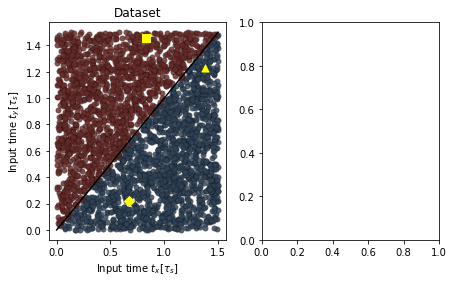

In [156]:
blue = np.array([[47, 66, 87, 210]]) / 256
red = np.array([[103, 43, 40, 210]]) / 256
black = np.array([[0, 0, 0, 0.3]])

def plt_dataset(ax: Axes, dataset: Dataset, observe: List[Tuple[int, int, str]], tau_syn_inv: ArrayLike):
    x = dataset[0].time[..., 0].flatten() * tau_syn_inv
    y = dataset[0].time[..., 1].flatten() * tau_syn_inv
    label = np.argmin(dataset[1], axis=-1).flatten()
    ax.scatter(
        x[label == 0],
        y[label == 0],
        s=30,
        facecolor=blue,
        edgecolor=black,
        linewidths=0.7,
    )
    ax.scatter(
        x[label == 1],
        y[label == 1],
        s=30,
        facecolor=red,
        edgecolor=black,
        linewidths=0.7,
    )
    for ix1, ix2, marker in observe:
        coords = dataset[0].time[ix1, ix2] * tau_syn_inv
        x, y = coords[0], coords[1]
        ax.scatter(x, y, marker=marker, color="yellow", s=50)
    ax.plot(np.linspace(0, 1.5, 100), np.linspace(0, 1.5, 100), c="k")
    ax.set_xlabel(r"Input time $t_x [\tau_s]$")
    ax.set_ylabel(r"Input time $t_y [\tau_s]$")
    ax.title.set_text("Dataset")

fig, ax1 = plt.subplots(1, 2, figsize=(7, 4))
plt_dataset(ax1[0], testset, items, LIFParameters.tau_syn_inv)

In [14]:
from jaxsnn.base.types import Array, Spike, Weight, ArrayLike
import jax.numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

def log_loss(first_spikes: Array, target: Array, tau_mem: float) -> ArrayLike:
    loss_value = -np.sum(np.log(1 + np.exp(-np.abs(first_spikes - target) / tau_mem)))
    return loss_value

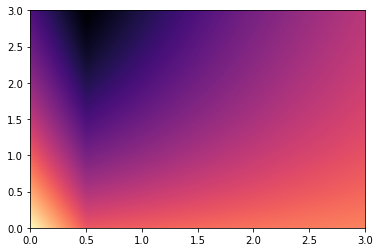

In [34]:
n = 100
tau_syn = 5e-3
tau_mem = 1e-2
target = np.array([0.5, 2.5]) * tau_syn

def loss_fn_vec(t1, t2, target_1, target_2, tau_mem):
    a = 1 + np.exp(-np.abs(t1 - target_1) / tau_mem)
    c = 1 + np.exp(-(t1 + t2) / tau_mem)
    loss_value = -(np.log(a / c))
    # loss_value = - (a +b)
    return loss_value

# units of tau syn
t1 = np.linspace(0, 3, n)
t2 = np.linspace(0, 3, n)
xx, yy = np.meshgrid(t1, t2)
zz = loss_fn_vec(xx * tau_syn, yy * tau_syn, target[0], target[1], tau_mem)

plt.contourf(t1, t2, zz, levels=500, cmap= mpl.colormaps["magma"])
plt.show()